# Imports and settings.

In [ ]:
# Imports and settings.
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from torch.autograd import Variable
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertModel
from transformers import get_linear_schedule_with_warmup



warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

     |████████████████████████████████| 890kB 14.2MB/s 
     |████████████████████████████████| 890kB 50.8MB/s 
     |████████████████████████████████| 3.0MB 49.8MB/s 
     |████████████████████████████████| 1.1MB 49.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=7ac5462b87f2161ee25073e848d8f70907ba73949ffadb27bc0f6082dcdc3d88
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#Download Tec, CF and Wang datasets and NRC and EmoSenticNet lexicon datasets
!git clone https://gitlab.com/Georgios.Hadjiharalambous/emotion-detection-in-short-texts-datasets
!cp './emotion-detection-in-short-texts-datasets/CrowdFlower.csv' 'CrowdFlower.csv'
!cp './emotion-detection-in-short-texts-datasets/Wang.csv' 'Wang.csv'
!cp './emotion-detection-in-short-texts-datasets/TEC.csv' 'TEC.csv'

Cloning into 'emotion-detection-in-short-texts-datasets'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


# Model defintion


In [ ]:
#This class is the implementation of Bert hierarchical with multiple positive emotions classifier.
#We use the Bert model implementation as provided by the huggingface library
#Link can be fount at https://huggingface.co/transformers/_modules/transformers/modeling_bert.html

class BertClassifierHier3Pos(nn.Module):
    def __init__(self, model_name, num_labels_neg, num_labels_pos, dropout_prob=0.5, bert_hidden_size=768):
        # Initializes the BertClassifierHier3Pos model object.      
        # Parameters:
        #     model_name: {String} exact name of the Bert model to be used during training. (Usually "bert-base-uncased")
        #     num_labels_neg: {int} Number of negative labels used during classification.
        #     num_labels_pos: {int} Number of positive labels used during classification.
        #     dropout_prob : {float} The dropout probability for the classification layer.
        #     bert_hidden_size: {int} Bert hidden dimension for its last-output layer. (Usually for "bert-base-uncased" is 768)
        
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_prob)
        self.l1_bin = nn.Linear(bert_hidden_size,1)#for the binary category classifier (output: negative/positive)
        self.l2_mul_neg= nn.Linear(bert_hidden_size, num_labels_neg)#for the negative category classifier (output: sadness/fear/anger) 
        self.l2_mul_pos= nn.Linear(bert_hidden_size, num_labels_pos)#for the positive category classifier (output: happiness/love/thankfulness) 

    def forward(self, input_ids = None, attention_mask = None, index = None):
        # Processes the input data to produce the classification output and the attention weight tensor.

        # Parameters:
        #     input_data: {torch.Tensor} Input data.
        #     attention_mask: {torch.Tensor} Indices to avoid performing attention to due to padded tokens
        #     index: {list} List that has two list of indices of rows in input_data that represent dataset entries belonging to negative emotion classes.
        #                     Only employed during model training. (usually equal to  [negative_list, positive_list])
        
           
        outputs = self.bert(input_ids, attention_mask = attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)

        #binary classification
        outputs_bin = self.l1_bin(pooled_output)
        outputs_bin = torch.sigmoid(outputs_bin)
        output_mul_neg = pooled_output
        output_mul_pos = pooled_output
        #mutliclass-negative emotion classification
        if index is not None:
          output_mul_neg = pooled_output[index[0]]#use only the negative examples for training of the second classifier.
          output_mul_pos = pooled_output[index[1]]#use only the positive examples for training of the third classifier.
          
        output_mul_neg = self.l2_mul_neg(output_mul_neg)
        output_mul_neg = torch.log_softmax(output_mul_neg,1) 

        output_mul_pos = self.l2_mul_pos(output_mul_pos)
        output_mul_pos = torch.log_softmax(output_mul_pos,1) 

        return outputs_bin , output_mul_neg, output_mul_pos#return all three classifier's output results

# Evaluation functions


In [ ]:
def get_classes_stats(predicted_output, true_output):

    # Returns the calculated evaluation metrics for each class.
    
    # Parameters:
    #     predicted_output: {numpy.array} Predicted output.
    #     true_output: {numpy.array} True output.

    report_dict = classification_report(true_output, predicted_output, output_dict=True)
    classes = []
    classes_stats = []
    for key in report_dict:
        if key not in ["accuracy", "macro avg", "weighted avg"]:
          classes.append(int(float(key)))
          stats = [float("%0.3f" % (report_dict[key]['precision'])), float("%0.3f" % (report_dict[key]['recall'])), 
                    float("%0.3f" % (report_dict[key]['f1-score'])), report_dict[key]['support']]
          classes_stats.append(stats)
    return [classes, classes_stats]
def create_report(parameters, run_function, num_classes, num_iters):

    # Creates an overall evaluation report after training and testing a model on binary or multiclass classification for a set number of iterations.

    # Parameters:
    #     parameters: {list} List of parameters.
    #     run_function: {function} Function to train and test a model on binary or multiclass classification.
    #     num_classes: {int} Number of classes.
    #     num_iters: {int} Number of iterations.

    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    classes = {}
    print("CREATING REPORT:")
    for i in range(num_iters):
        print("Run: " + str(i + 1))
        result = run_function(parameters[0], parameters[1], parameters[2], parameters[3], False)
        print("Accuracy: %0.3f" % result[0][0])
        print("Precision (WEIGHT_AVG): %0.3f" % result[0][1])
        print("Recall (WEIGHT_AVG): %0.3f" % result[0][2])
        print("F1 (WEIGHT_AVG): %0.3f" % result[0][3])
        accuracy_list.append(result[0][0])
        precision_list.append(result[0][1])
        recall_list.append(result[0][2])
        f1_list.append(result[0][3])
        for j in range(1, num_classes + 1, 1):
            print((str(result[j][0]) + " | Precision: %0.3f Recall: %0.3f F1: %0.3f") % (result[j][1], result[j][2], result[j][3]))
            if result[j][0] not in classes:
                classes[result[j][0]] = {}
            if "Precision_List" not in classes[result[j][0]]:
                classes[result[j][0]]["Precision_List"] = []
            classes[result[j][0]]["Precision_List"].append(result[j][1])
            if "Recall_List" not in classes[result[j][0]]:
                classes[result[j][0]]["Recall_List"] = []
            classes[result[j][0]]["Recall_List"].append(result[j][2])
            if "F1_List" not in classes[result[j][0]]:
                classes[result[j][0]]["F1_List"] = []
            classes[result[j][0]]["F1_List"].append(result[j][3])
    general_stats = [["%0.3f [%0.3f]" % (np.mean(np.asarray(accuracy_list)), np.std(np.asarray(accuracy_list))), 
                      "%0.3f [%0.3f]" % (np.mean(np.asarray(precision_list)), np.std(np.asarray(precision_list))), 
                      "%0.3f [%0.3f]" % (np.mean(np.asarray(recall_list)), np.std(np.asarray(recall_list))), 
                      "%0.3f [%0.3f]" % (np.mean(np.asarray(f1_list)), np.std(np.asarray(f1_list)))]]
    class_labels = []
    class_stats = []
    for key in classes:
        class_labels.append(key)
        precision = "%0.3f [%0.3f]" % (np.mean(np.asarray(classes[key]["Precision_List"])), np.std(np.asarray(classes[key]["Precision_List"])))
        recall = "%0.3f [%0.3f]" % (np.mean(np.asarray(classes[key]["Recall_List"])), np.std(np.asarray(classes[key]["Recall_List"])))
        f1 = "%0.3f [%0.3f]" % (np.mean(np.asarray(classes[key]["F1_List"])), np.std(np.asarray(classes[key]["F1_List"])))
        class_stats.append([precision, recall, f1])
    fig = plt.figure()
    ax = fig.add_subplot(3, 1, 1)  
    col_labels = ["Accuracy [STD]", "Precision (WEIGHT_AVG) [STD]", "Recall (WEIGHT_AVG) [STD]", "F1 (WEIGHT_AVG) [STD]"]
    table = ax.table(cellText=general_stats, rowLabels=[parameters[0]], colLabels=col_labels, loc='center')
    table.scale(3, 3)
    ax.axis('off')
    ax = fig.add_subplot(3, 1, 3)
    col_labels = ["Precision [STD]", "Recall [STD]", "F1 [STD]"]
    table = ax.table(cellText=class_stats, rowLabels=class_labels, colLabels=col_labels, loc='center')
    table.scale(3, 3)
    ax.axis('off')

def plot_confusion_matrix(description, predicted_output, true_output, labels_dict, normalize=False):

    # Plots a confusion matrix for the predicted output.

    # Parameters:
    #     description: {str} Description.
    #     predicted_output: {numpy.array} Predicted output.
    #     true_output: {numpy.array} True output.
    #     labels_dict: {dict} Dictionary of class labels.
    #     normalize: {bool} Normalize values or not.

    title = "Confusion matrix: '%s'" % (description)
    if normalize:
        title = title + " (Normalized)"
    cm = confusion_matrix(true_output, predicted_output)
    classes = get_classes_stats(predicted_output, true_output)[0]
    labels = []
    for item in classes:
        labels.append(labels_dict[item])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(1, 1, 1)
    cmap = plt.cm.Blues
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), yticklabels=labels)
    ax.set_xticklabels(labels, rotation='vertical')
    ax.set_title(title, fontsize=20)
    ax.set_ylabel("True labels", fontsize=20)
    ax.set_xlabel("Predicted labels", fontsize=20)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    ax.grid(False)

# Dataset loading and processing functions


In [ ]:
def load_wang_hier_6():

    # Loads the Wang dataset for multiclass classification with the Bert(Hier3Pos) model. 

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness", 4: "Love", 5: "Thankfulness"}
    dataframe = pd.read_csv("Wang.csv", delimiter=",", dtype={"id": int, "text": str, "emotion": str})
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("joy", 3)
    dataframe["emotion"] = dataframe["emotion"].replace("love", 4).replace("thankfulness", 5)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 10000
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_love = dataframe[dataframe.emotion == 4][:min_size]
    dataframe_thankfulness = dataframe[dataframe.emotion == 5][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_love_train = dataframe_love[:int(0.8 * min_size)]
    dataframe_love_test = dataframe_love[int(0.8 * min_size):]
    dataframe_thankfulness_train = dataframe_thankfulness[:int(0.8 * min_size)]
    dataframe_thankfulness_test = dataframe_thankfulness[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train, dataframe_love_train, 
                                 dataframe_thankfulness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test, dataframe_love_test,
                                dataframe_thankfulness_test]).sample(frac=1).reset_index(drop=True)
    dataframe_train["emotion"] = [[0, emotion, -1] if emotion < 3 else [1, -1, emotion - 3] for emotion in dataframe_train.emotion]
    dataframe_test_true = dataframe_test.copy()
    dataframe_test["emotion"] = [[0, emotion, -1] if emotion < 3 else [1, -1, emotion - 3] for emotion in dataframe_test.emotion]
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"], dataframe_test_true["emotion"]]
    return train_list, test_list, labels_dict

def load_wang_hier_5():

    # Loads the Wang dataset for multiclass classification with the Bert(Hier2Pos) model. 

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness", 4: "Love"}
    dataframe = pd.read_csv("Wang.csv", delimiter=",", dtype={"id": int, "text": str, "emotion": str})
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)
    dataframe = dataframe[dataframe.emotion != "thankfulness"]
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("joy", 3)
    dataframe["emotion"] = dataframe["emotion"].replace("love", 4)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    negative_count = 10000
    positive_count = negative_count * 3 / 2
    dataframe_anger = dataframe[dataframe.emotion == 0].sample(negative_count)
    dataframe_fear = dataframe[dataframe.emotion == 1].sample(negative_count)
    dataframe_sadness = dataframe[dataframe.emotion == 2].sample(negative_count)
    dataframe_happiness = dataframe[dataframe.emotion == 3].sample(int(positive_count))
    dataframe_love = dataframe[dataframe.emotion == 4].sample(int(positive_count))
    dataframe_anger_train = dataframe_anger[:int(0.8 * negative_count)]
    dataframe_anger_test = dataframe_anger[int(0.8 * negative_count):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * negative_count)]
    dataframe_fear_test = dataframe_fear[int(0.8 * negative_count):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * negative_count)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * negative_count):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * positive_count)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * positive_count):]
    dataframe_love_train = dataframe_love[:int(0.8 * positive_count)]
    dataframe_love_test = dataframe_love[int(0.8 * positive_count):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train, dataframe_love_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test, dataframe_love_test]).sample(frac=1).reset_index(drop=True)
    dataframe_train["emotion"] = [[0, emotion, -1] if emotion < 3 else [1, -1, emotion - 3] for emotion in dataframe_train.emotion]
    dataframe_test_true = dataframe_test.copy()
    dataframe_test["emotion"] = [[0, emotion, -1] if emotion < 3 else [1, -1, emotion - 3] for emotion in dataframe_test.emotion]
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"], dataframe_test_true["emotion"]]
    return train_list, test_list, labels_dict


def load_vent_hier_6():

    # Loads the Wang dataset for multiclass classification with the Bert(Hier3Pos) model. 

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness", 4: "Love", 5: "Thankfulness"}
    dataframe = pd.read_csv("cent6_emot.csv", delimiter=",", dtype={ "emotion": str,  "text": str})
    dataframe.text.astype(str)
    dataframe = dataframe.drop(dataframe.columns[[0]], axis=1)    
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("happiness", 3)
    dataframe["emotion"] = dataframe["emotion"].replace("love", 4).replace("thankfulness", 5)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 10000
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_love = dataframe[dataframe.emotion == 4][:min_size]
    dataframe_thankfulness = dataframe[dataframe.emotion == 5][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_love_train = dataframe_love[:int(0.8 * min_size)]
    dataframe_love_test = dataframe_love[int(0.8 * min_size):]
    dataframe_thankfulness_train = dataframe_thankfulness[:int(0.8 * min_size)]
    dataframe_thankfulness_test = dataframe_thankfulness[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train, dataframe_love_train, 
                                 dataframe_thankfulness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test, dataframe_love_test,
                                dataframe_thankfulness_test]).sample(frac=1).reset_index(drop=True)
    dataframe_train["emotion"] = [[0, emotion, -1] if emotion < 3 else [1, -1, emotion - 3] for emotion in dataframe_train.emotion]
    dataframe_test_true = dataframe_test.copy()
    dataframe_test["emotion"] = [[0, emotion, -1] if emotion < 3 else [1, -1, emotion - 3] for emotion in dataframe_test.emotion]
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"], dataframe_test_true["emotion"]]
    return train_list, test_list, labels_dict


def load_vent_hier_5():

    # Loads the Wang dataset for multiclass classification with the Bert(Hier2Pos) model. 
    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness", 4: "Love"}
    dataframe = pd.read_csv("cent5_emot.csv", delimiter=",", dtype={ "emotion": str,  "text": str})
    dataframe.text.astype(str)
    dataframe = dataframe.drop(dataframe.columns[[0]], axis=1)    
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("happiness", 3)
    dataframe["emotion"] = dataframe["emotion"].replace("love", 4)  
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    negative_count = 10000
    positive_count = negative_count * 3 / 2
    dataframe_anger = dataframe[dataframe.emotion == 0].sample(negative_count)
    dataframe_fear = dataframe[dataframe.emotion == 1].sample(negative_count)
    dataframe_sadness = dataframe[dataframe.emotion == 2].sample(negative_count)
    dataframe_happiness = dataframe[dataframe.emotion == 3].sample(int(positive_count))
    dataframe_love = dataframe[dataframe.emotion == 4].sample(int(positive_count))
    dataframe_anger_train = dataframe_anger[:int(0.8 * negative_count)]
    dataframe_anger_test = dataframe_anger[int(0.8 * negative_count):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * negative_count)]
    dataframe_fear_test = dataframe_fear[int(0.8 * negative_count):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * negative_count)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * negative_count):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * positive_count)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * positive_count):]
    dataframe_love_train = dataframe_love[:int(0.8 * positive_count)]
    dataframe_love_test = dataframe_love[int(0.8 * positive_count):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train, dataframe_love_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test, dataframe_love_test]).sample(frac=1).reset_index(drop=True)
    dataframe_train["emotion"] = [[0, emotion, -1] if emotion < 3 else [1, -1, emotion - 3] for emotion in dataframe_train.emotion]
    dataframe_test_true = dataframe_test.copy()
    dataframe_test["emotion"] = [[0, emotion, -1] if emotion < 3 else [1, -1, emotion - 3] for emotion in dataframe_test.emotion]
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"], dataframe_test_true["emotion"]]
    return train_list, test_list, labels_dict        

In [ ]:
def tokenize_map_pad_mask(sentences,MAX_LEN = 35):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'                       
                  )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)
    #pad the sentences   
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                        value=0, truncating="post", padding="post")
    

  # Create attention masks which provide the indices to avoid performing attention to due to padded tokens
  attention_masks = []
  for sent in input_ids:        
      # Create the attention mask.
      #   - If a token ID is 0, then it's padding, set the mask to 0.
      #   - If a token ID is > 0, then it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in sent]      
      attention_masks.append(att_mask)
  return input_ids,attention_masks 

# Training and testing functions


In [ ]:
def train(model, train_dataloader, gradient_clipping, scheduler, optimizer, criteria, num_epochs=1, verbose=False):
  # Trains the BertClassifierHier3Pos model for multiclass classification 
  # Parameters:
  #     model: {BertClassifierHier3Pos} Bert hierarchical classifier model to be trained.
  #     train_dataloader: {torch.utils.data.DataLoader} Data loader containing training data.
  #     gradient_clipping: {bool} Use gradient clipping or not.
  #     scheduler: Used for adapting learning rate.
  #     optimizer: {torch.optim.RMSprop} Optimizer to be used in training.
  #     criteria: {list of torch loss functions. 1st element is torch.nn.BCELoss(),2nd element is torch.nn.NLLLoss(), 3rd element is torch.nn.NLLLoss()}
  #     num_epochs: {int} Number of epochs.
  #     verbose: {bool} Verbose or not.
  num_batches=0
  losses=[]
  if torch.cuda.is_available():    
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

  # Store the average loss after each epoch.
  loss_values = []
  accuracies = []
  criterion_l1 = criteria[0]
  criterion_l2_neg = criteria[1]  
  criterion_l2_pos = criteria[2]  

  for epoch_i in range(0, num_epochs):

      if verbose:
        print("Running epoch: " + str(epoch_i + 1))
      total_loss = 0
      total_loss_l1 = 0
      total_loss_l2_pos = 0
      total_loss_l2_neg = 0
      num_batches = 0
      num_negative = 0
      num_positive = 0
      correct = 0
      correct_l1 = 0
      correct_l2_pos = 0    
      correct_l2_neg = 0    
            
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):       

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          input_ids = batch[0].to(device)
          input_mask = batch[1].to(device)
          output_l1, output_l2_neg, output_l2_pos = batch[2][:,0], batch[2][:,1], batch[2][:,2]
          negative_index = np.where(output_l1 == 0)[0].tolist()
          positive_index = np.where(output_l1 == 1)[0].tolist()
          num_negative += len(negative_index)
          num_positive += len(positive_index)
          index = [negative_index, positive_index]
          output_l1 = Variable(output_l1.type(torch.DoubleTensor))
          output_l2_neg = Variable(output_l2_neg[negative_index].type(torch.LongTensor)) #.to(device)
          output_l2_pos = Variable(output_l2_pos[positive_index].type(torch.LongTensor)) #.to(device)
          labels = batch[2].to(device)

          model.zero_grad()        

          predicted_output_l1, predicted_output_l2_neg, predicted_output_l2_pos = model(input_ids, 
                      attention_mask=input_mask, 
                      index=index)
          
          
          loss_l1 = criterion_l1(predicted_output_l1.type(torch.DoubleTensor).squeeze(1), output_l1)          
          loss_l2_neg = criterion_l2_neg(predicted_output_l2_neg.type(torch.DoubleTensor), output_l2_neg)
          loss_l2_pos = criterion_l2_pos(predicted_output_l2_pos.type(torch.DoubleTensor), output_l2_pos)

                      
          loss = loss_l1 + loss_l2_neg + loss_l2_pos
          
          total_loss += loss.item()
          total_loss_l1 += loss_l1.item()
          total_loss_l2_neg += loss_l2_neg.item()
          total_loss_l2_pos += loss_l2_pos.item()

          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          if gradient_clipping:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
            
          optimizer.step()

          # Update the learning rate.
          scheduler.step()
          
          num_batches += 1    
      if verbose:
        print("Average loss: %0.3f" % (total_loss / num_batches))
      
      losses.append(total_loss / num_batches)
  return losses, accuracies

In [ ]:
def evaluate(model, test_output, prediction_dataloader,verbose=True):
  # Put model in evaluation mode
  model.eval()

  if torch.cuda.is_available():    
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")

  test_output_l1 = test_output[:, 0]
  test_output_l2_neg = test_output[:, 1]
  test_output_l2_pos = test_output[:, 2]  

  # Tracking variables 
  predictions , true_labels = [], []
  predictions_l1, predictions_l2_neg, predictions_l2_pos = [], [], []
  true_labels_l1, true_labels_l2_neg, true_labels_l2_pos = [],[], []

  # Predict 
  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        predicted_output_l1, predicted_output_l2_neg, predicted_output_l2_pos = model(input_ids,  attention_mask=input_mask)

    # Move logits and labels to CPU
    predicted_output_l1 = predicted_output_l1.detach().cpu().numpy()
    predicted_output_l2_neg = predicted_output_l2_neg.detach().cpu().numpy()
    predicted_output_l2_pos = predicted_output_l2_pos.detach().cpu().numpy()

    label_l1, label_l2_neg, label_l2_pos =labels[:,0].to('cpu').numpy(), labels[:,1].to('cpu').numpy(), labels[:,2].to('cpu').numpy()
    
    # Store predictions and true labels
    predictions_l1.extend(predicted_output_l1)
    predictions_l2_neg.extend(predicted_output_l2_neg)
    predictions_l2_pos.extend(predicted_output_l2_pos)

    true_labels_l1.extend(label_l1)
    true_labels_l2_neg.extend(label_l2_neg)
    true_labels_l2_pos.extend(label_l2_pos)

  predsl1 = []
  predsl2_neg = []
  predsl2_pos = []

  for batch in predictions_l1:
    predsl1.extend(batch)
  for batch in predictions_l2_neg:
    predsl2_neg.extend(batch)     
  for batch in predictions_l2_pos:
    predsl2_pos.extend(batch)

  predictions_l1=torch.from_numpy(np.array(predsl1))
  predictions_l2_neg=torch.from_numpy(np.array(predictions_l2_neg))
  predictions_l2_pos=torch.from_numpy(np.array(predictions_l2_pos))

  binary_predicted_test_output_l1 = torch.round(predictions_l1)
  test_output_var_l1 = Variable(torch.from_numpy(np.array(true_labels_l1)).type(torch.DoubleTensor))

  multiclass_predicted_test_output_l2_neg = torch.max(predictions_l2_neg, 1)[1]
  test_output_var_l2_neg = Variable(torch.from_numpy(np.array(true_labels_l2_neg)).type(torch.LongTensor))

  multiclass_predicted_test_output_l2_pos = torch.max(predictions_l2_pos, 1)[1]
  test_output_var_l2_pos = Variable(torch.from_numpy(np.array(true_labels_l2_pos)).type(torch.LongTensor))

  correct_l1 = torch.eq(binary_predicted_test_output_l1, test_output_var_l1).data.sum()
  correct_l1_np = correct_l1.data.cpu().numpy().astype(int)

  correct_l2_neg = torch.eq(multiclass_predicted_test_output_l2_neg, test_output_var_l2_neg).data.sum()
  correct_l2_np_neg = correct_l2_neg.data.cpu().numpy().astype(int)
  
  correct_l2_pos = torch.eq(multiclass_predicted_test_output_l2_pos, test_output_var_l2_pos).data.sum()
  correct_l2_np_pos = correct_l2_pos.data.cpu().numpy().astype(int)

  binary_predicted_test_output_l1 = binary_predicted_test_output_l1.detach().numpy()
  negative_index = np.where(binary_predicted_test_output_l1 == 0)[0].tolist()
  positive_index = np.where(binary_predicted_test_output_l1 == 1)[0].tolist()

  accuracy_l1 = correct_l1_np / float(len(binary_predicted_test_output_l1))
  accuracy_l2_neg = correct_l2_np_neg / float(len(negative_index))
  accuracy_l2_pos = correct_l2_np_pos / float(len(positive_index))

  multiclass_predicted_test_output_l2_neg = multiclass_predicted_test_output_l2_neg.detach().numpy()
  multiclass_predicted_test_output_l2_pos = multiclass_predicted_test_output_l2_pos.detach().numpy()

  correct = 0
  final_predicted_test_output = []
  for i in range(len(binary_predicted_test_output_l1)):
      if binary_predicted_test_output_l1[i] == 1:
            if test_output_l1[i] == 1:
                if multiclass_predicted_test_output_l2_pos[i] == test_output_l2_pos[i]:
                    correct += 1
            final_predicted_test_output.append(multiclass_predicted_test_output_l2_pos[i] + 3)
      else:
            if test_output_l1[i] == 0:
                if multiclass_predicted_test_output_l2_neg[i] == test_output_l2_neg[i]:
                    correct += 1
            final_predicted_test_output.append(multiclass_predicted_test_output_l2_neg[i])
  accuracy = correct / float(len(binary_predicted_test_output_l1))
  if verbose:
      print("Accuracy: %0.3f" % (accuracy))
      print("Accuracy_l1: %0.3f" % (accuracy_l1))
      print("Accuracy_l2_neg: %0.3f" % (accuracy_l2_neg))
      print("Accuracy_l2_pos: %0.3f" % (accuracy_l2_pos))
  return accuracy, final_predicted_test_output

In [ ]:
def evaluation_summary(description, predicted_output, true_output, labels_dict, verbose=True):

    # Returns an evaluation report for the predicted output.

    # Parameters:
    #     description: {str} Description.
    #     predicted_output: {numpy.array} Predicted output.
    #     true_output: {numpy.array} True output.
    #     labels_dict: {dict} Dictionary of class labels.
    #     verbose: {bool} Verbose or not.

    

    precision = precision_score(true_output, predicted_output, average='weighted')
    recall = recall_score(true_output, predicted_output, average='weighted')
    accuracy = accuracy_score(true_output, predicted_output)
    f1 = fbeta_score(true_output, predicted_output, 1, average='weighted')
    classes = get_classes_stats(predicted_output, true_output)[0]
    classes_stats = get_classes_stats(predicted_output, true_output)[1]
    result = [[accuracy, precision, recall, f1]]
    if verbose:
        print("Classifier '%s':" % (description))
        print("Accuracy: %0.3f" % (accuracy))
        print("Precision (WEIGHT_AVG): %0.3f" % (precision))
        print("Recall (WEIGHT_AVG): %0.3f" % (recall))
        print("F1 (WEIGHT_AVG): %0.3f" % (f1))
    for i in range(len(classes)):
        if verbose:
            print((labels_dict[classes[i]] + " | Precision: %0.3f Recall: %0.3f F1: %0.3f Support: " + str(classes_stats[i][3])) % 
                  (classes_stats[i][0], classes_stats[i][1], classes_stats[i][2]))
        result.append([labels_dict[classes[i]], classes_stats[i][0], classes_stats[i][1], classes_stats[i][2]])
    return result

In [ ]:
def load_dataset(load_function, batch_size,max_len, target=None):
    
    # Processes a dataset for the training and testing of the SASE model.

    # Parameters:
    #     load_function: {function} Function to load a dataset.
    #     num_timesteps: {int} Number of LSTM timesteps.
    #     vocabulary_size: {int} Maximal size of the vocabulary.
    #     batch_size: {int} Batch size used in model training.
    #     target: {str} Target class.
    
    if target == None:
        train_set, test_set, labels_dict = load_function()
    else:
        train_set, test_set, labels_dict = load_function(target)
    train_input, train_output = train_set[0], train_set[1]
    test_input, test_output, true_test_output = test_set[0], test_set[1], test_set[2]

    train_input,train_masks = tokenize_map_pad_mask(train_input,max_len)

    train_input = torch.tensor(train_input)
    train_output = torch.tensor(train_output)
    train_masks = torch.tensor(train_masks)

    batch_size = batch_size
    
    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_input, train_masks, train_output)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create sentence and label lists
    test_input, test_masks= tokenize_map_pad_mask(test_input,max_len)

    # Convert to tensors.
    test_input = torch.tensor(test_input)
    test_output = torch.tensor(test_output)  
    test_masks = torch.tensor(test_masks)

    # Create the DataLoader.
    test_data = TensorDataset(test_input, test_masks, test_output)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    return train_dataloader, test_dataloader, test_output, true_test_output, labels_dict

In [ ]:
def run_multiclass_model(model_name, model_parameters, train_parameters, load_function, verbose=True):

    # Trains and tests the Bert model on multiclass classification.

    # Parameters:
    #     model_name: {str} Name of the model.
    #     model_parameters: {dict} Dictionary of model parameters.
    #     train_parameters: {dict} Dictionary of training parameters.
    #     load_function: {function} Function to load a dataset.
    #     verbose: {bool} Verbose or not.

    train_dataloader, test_dataloader, test_output, true_test_output , labels_dict = load_dataset(load_function, model_parameters["batch_size"],
                                                                               max_len = model_parameters["num_timesteps"])
    




    # Load BertClassifierHier3Pos model
    model = BertClassifierHier3Pos(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    model_parameters["num_classes_negative"], 
    model_parameters["num_classes_positive"],  
    dropout_prob=0.1,
    bert_hidden_size=768,
    )
    model.cuda()

    total_steps = len(train_dataloader) * train_parameters["num_epochs"]

    # Create the learning rate scheduler.
    optimizer = AdamW(model.parameters(),
                      lr = 2e-5, 
                      eps = 1e-8 
                    )

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
    
    criteria = [torch.nn.BCELoss(), torch.nn.NLLLoss(), torch.nn.NLLLoss()]

    
    if verbose:
        print("MODEL: " + model_name)
    if verbose:
        print("TRAINING:")
    losses, accuracies = train(model,train_dataloader,train_parameters["gradient_clipping"],scheduler,optimizer,criteria,train_parameters["num_epochs"],verbose)

  
    if verbose:
        print("POST-TRAINING:")
    post_accuracy, post_predicted_test_output = evaluate(model, test_output,test_dataloader, verbose)
    if verbose:
        print("EVALUATION REPORT:")
    result = evaluation_summary(model_name, post_predicted_test_output, true_test_output, labels_dict, verbose)
    if verbose:
        plot_confusion_matrix(model_name, post_predicted_test_output, true_test_output, labels_dict)
        plot_confusion_matrix(model_name, post_predicted_test_output, true_test_output, labels_dict, True)
    return result

# Multiclass Classification Tests


In [ ]:
#Evaluate Wang dataset with 5 emotions using Bert hierarchical classifier model
train_parameters = {
    "num_epochs": 4,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 64,
    "num_timesteps": 35,
    "num_classes_negative": 3,
    "num_classes_positive":2,
    "num_classes":5
}

result = run_multiclass_model("Wang(MULTICLASS) 5 classes", model_parameters, train_parameters, load_wang_hier_5)
parameters = ["Wang(MULTICLASS) 5 classes", model_parameters, train_parameters, load_wang_hier_5]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)


MODEL: Wang(MULTICLASS) 5 classes
TRAINING:
Running epoch: 1
Average loss: 1.835
Running epoch: 2


In [ ]:
#Evaluate Wang dataset with 6 emotions using Bert hierarchical classifier model
train_parameters = {
    "num_epochs": 4,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 64,
    "num_timesteps": 35,
    "num_classes_negative": 3,
    "num_classes_positive":3,
    "num_classes":6
}

result = run_multiclass_model("Wang(MULTICLASS) 6 classes", model_parameters, train_parameters, load_wang_hier_6)
parameters = ["Wang(MULTICLASS) 6 classes", model_parameters, train_parameters, load_wang_hier_6]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)

Token indices sequence length is longer than the specified maximum sequence length for this model (1446 > 512). Running this sequence through the model will result in indexing errors



MODEL: Wang(MULTICLASS) 6 classes
TRAINING:
Running epoch: 1
Average loss: 1.991
Running epoch: 2
Average loss: 1.600
Running epoch: 3
Average loss: 1.467
Running epoch: 4
Average loss: 1.386
POST-TRAINING:
Accuracy: 0.620
Accuracy_l1: 0.848
Accuracy_l2_neg: 0.622
Accuracy_l2_pos: 0.832
EVALUATION REPORT:
Classifier 'Wang(MULTICLASS) 6 classes':
Accuracy: 0.620
Precision (WEIGHT_AVG): 0.627
Recall (WEIGHT_AVG): 0.620
F1 (WEIGHT_AVG): 0.621
Anger | Precision: 0.587 Recall: 0.633 F1: 0.609 Support: 2000
Fear | Precision: 0.613 Recall: 0.568 F1: 0.589 Support: 2000
Sadness | Precision: 0.505 Recall: 0.605 F1: 0.551 Support: 2000
Happiness | Precision: 0.677 Recall: 0.710 F1: 0.693 Support: 3000
Love | Precision: 0.694 Recall: 0.567 F1: 0.624 Support: 3000
CREATING REPORT:
Run: 1


Token indices sequence length is longer than the specified maximum sequence length for this model (1446 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.624
Precision (WEIGHT_AVG): 0.630
Recall (WEIGHT_AVG): 0.624
F1 (WEIGHT_AVG): 0.624
Anger | Precision: 0.581 Recall: 0.638 F1: 0.608
Fear | Precision: 0.596 Recall: 0.576 F1: 0.586
Sadness | Precision: 0.518 Recall: 0.584 F1: 0.549
Happiness | Precision: 0.681 Recall: 0.730 F1: 0.705
Love | Precision: 0.710 Recall: 0.567 F1: 0.630
Run: 2
Accuracy: 0.618
Precision (WEIGHT_AVG): 0.623
Recall (WEIGHT_AVG): 0.618
F1 (WEIGHT_AVG): 0.617
Anger | Precision: 0.580 Recall: 0.638 F1: 0.608
Fear | Precision: 0.582 Recall: 0.581 F1: 0.581
Sadness | Precision: 0.531 Recall: 0.588 F1: 0.558
Happiness | Precision: 0.666 Recall: 0.722 F1: 0.693
Love | Precision: 0.698 Recall: 0.544 F1: 0.611
Run: 3


Token indices sequence length is longer than the specified maximum sequence length for this model (1672 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.625
Precision (WEIGHT_AVG): 0.630
Recall (WEIGHT_AVG): 0.625
F1 (WEIGHT_AVG): 0.626
Anger | Precision: 0.573 Recall: 0.660 F1: 0.613
Fear | Precision: 0.593 Recall: 0.593 F1: 0.593
Sadness | Precision: 0.537 Recall: 0.588 F1: 0.561
Happiness | Precision: 0.702 Recall: 0.689 F1: 0.695
Love | Precision: 0.684 Recall: 0.584 F1: 0.630
Run: 4
Accuracy: 0.628
Precision (WEIGHT_AVG): 0.633
Recall (WEIGHT_AVG): 0.628
F1 (WEIGHT_AVG): 0.629
Anger | Precision: 0.592 Recall: 0.656 F1: 0.622
Fear | Precision: 0.575 Recall: 0.597 F1: 0.586
Sadness | Precision: 0.537 Recall: 0.577 F1: 0.556
Happiness | Precision: 0.694 Recall: 0.716 F1: 0.705
Love | Precision: 0.701 Recall: 0.577 F1: 0.633
Run: 5


Token indices sequence length is longer than the specified maximum sequence length for this model (1446 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (901 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.622
Precision (WEIGHT_AVG): 0.627
Recall (WEIGHT_AVG): 0.622
F1 (WEIGHT_AVG): 0.622
Anger | Precision: 0.588 Recall: 0.630 F1: 0.609
Fear | Precision: 0.592 Recall: 0.594 F1: 0.593
Sadness | Precision: 0.526 Recall: 0.594 F1: 0.558
Happiness | Precision: 0.679 Recall: 0.722 F1: 0.700
Love | Precision: 0.691 Recall: 0.554 F1: 0.615


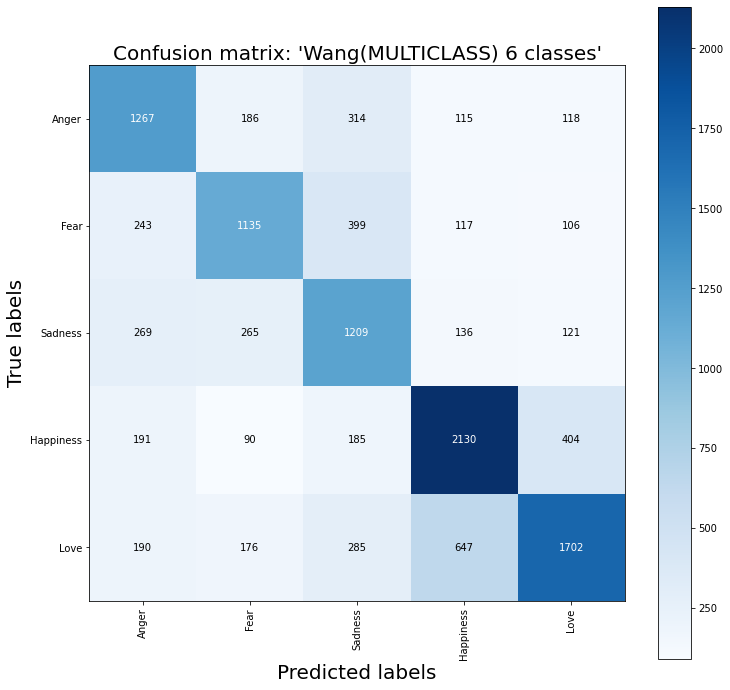

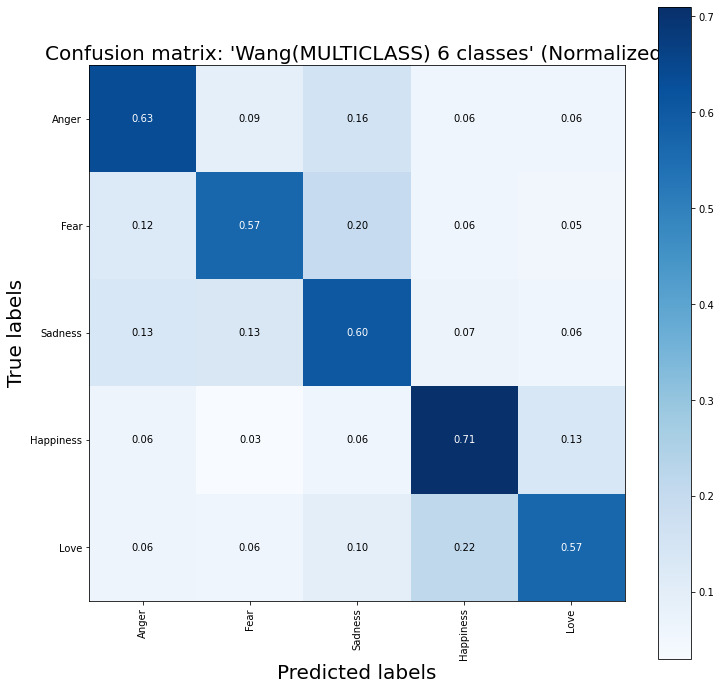

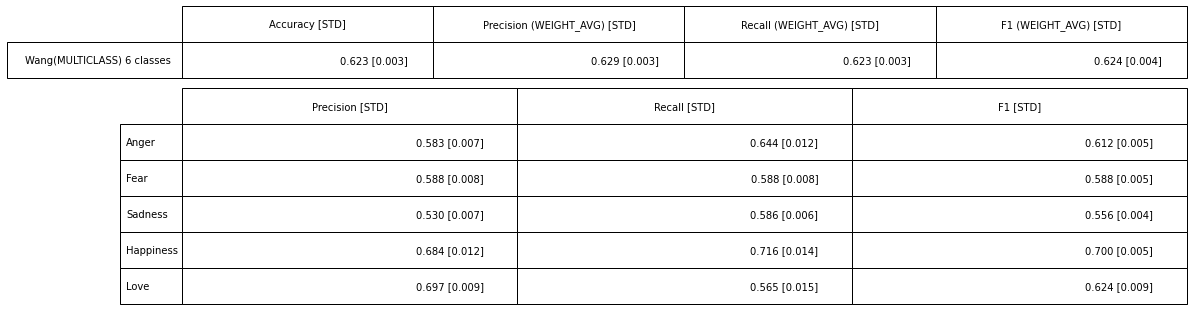

In [ ]:

#Evaluate Vent dataset with 5 emotions using Bert hierarchical classifier model
train_parameters = {
    "num_epochs": 4,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 256,
    "num_timesteps": 35,
    "num_classes_negative": 3,
    "num_classes_positive":3,
    "num_classes":5
}
#The dataset Vent is required to run this cell, which is not provided publicly due to authors restrictions

result = run_multiclass_model("Vent(MULTICLASS) 5 classes", model_parameters, train_parameters, load_vent_hier_5)
parameters = ["Vent(MULTICLASS) 5 classes", model_parameters, train_parameters, load_vent_hier_5]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)

Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


MODEL: Wang(MULTICLASS) 6 classes
TRAINING:
Running epoch: 1
Average loss: 2.150
Running epoch: 2
Average loss: 1.765
Running epoch: 3
Average loss: 1.545
Running epoch: 4
Average loss: 1.377
POST-TRAINING:
Accuracy: 0.585
Accuracy_l1: 0.864
Accuracy_l2_neg: 0.645
Accuracy_l2_pos: 0.685
EVALUATION REPORT:
Classifier 'Wang(MULTICLASS) 6 classes':
Accuracy: 0.585
Precision (WEIGHT_AVG): 0.588
Recall (WEIGHT_AVG): 0.585
F1 (WEIGHT_AVG): 0.586
Anger | Precision: 0.614 Recall: 0.641 F1: 0.628 Support: 2000
Fear | Precision: 0.620 Recall: 0.583 F1: 0.601 Support: 2000
Sadness | Precision: 0.531 Recall: 0.609 F1: 0.568 Support: 2000
Happiness | Precision: 0.554 Recall: 0.570 F1: 0.562 Support: 2000
Love | Precision: 0.569 Recall: 0.539 F1: 0.554 Support: 2000
Thankfulness | Precision: 0.637 Recall: 0.570 F1: 0.602 Support: 2000
CREATING REPORT:
Run: 1
Accuracy: 0.573
Precision (WEIGHT_AVG): 0.576
Recall (WEIGHT_AVG): 0.573
F1 (WEIGHT_AVG): 0.573
Anger | Precision: 0.604 Recall: 0.619 F1: 0.61

Token indices sequence length is longer than the specified maximum sequence length for this model (1446 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.585
Precision (WEIGHT_AVG): 0.588
Recall (WEIGHT_AVG): 0.585
F1 (WEIGHT_AVG): 0.585
Anger | Precision: 0.622 Recall: 0.630 F1: 0.626
Fear | Precision: 0.613 Recall: 0.594 F1: 0.603
Sadness | Precision: 0.514 Recall: 0.619 F1: 0.561
Happiness | Precision: 0.560 Recall: 0.566 F1: 0.563
Love | Precision: 0.588 Recall: 0.535 F1: 0.560
Thankfulness | Precision: 0.633 Recall: 0.567 F1: 0.598
Run: 3
Accuracy: 0.573
Precision (WEIGHT_AVG): 0.575
Recall (WEIGHT_AVG): 0.573
F1 (WEIGHT_AVG): 0.572
Anger | Precision: 0.609 Recall: 0.632 F1: 0.620
Fear | Precision: 0.587 Recall: 0.592 F1: 0.589
Sadness | Precision: 0.517 Recall: 0.580 F1: 0.547
Happiness | Precision: 0.533 Recall: 0.580 F1: 0.556
Love | Precision: 0.577 Recall: 0.476 F1: 0.522
Thankfulness | Precision: 0.626 Recall: 0.575 F1: 0.599
Run: 4
Accuracy: 0.585
Precision (WEIGHT_AVG): 0.588
Recall (WEIGHT_AVG): 0.585
F1 (WEIGHT_AVG): 0.584
Anger | Precision: 0.592 Recall: 0.664 F1: 0.626
Fear | Precision: 0.601 Recall: 0.575 F

Token indices sequence length is longer than the specified maximum sequence length for this model (901 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.578
Precision (WEIGHT_AVG): 0.581
Recall (WEIGHT_AVG): 0.578
F1 (WEIGHT_AVG): 0.579
Anger | Precision: 0.612 Recall: 0.615 F1: 0.613
Fear | Precision: 0.588 Recall: 0.588 F1: 0.588
Sadness | Precision: 0.523 Recall: 0.609 F1: 0.563
Happiness | Precision: 0.544 Recall: 0.571 F1: 0.557
Love | Precision: 0.579 Recall: 0.521 F1: 0.549
Thankfulness | Precision: 0.641 Recall: 0.567 F1: 0.602
Run: 6
Accuracy: 0.572
Precision (WEIGHT_AVG): 0.576
Recall (WEIGHT_AVG): 0.572
F1 (WEIGHT_AVG): 0.572
Anger | Precision: 0.605 Recall: 0.631 F1: 0.618
Fear | Precision: 0.611 Recall: 0.577 F1: 0.593
Sadness | Precision: 0.499 Recall: 0.590 F1: 0.540
Happiness | Precision: 0.525 Recall: 0.567 F1: 0.545
Love | Precision: 0.591 Recall: 0.486 F1: 0.533
Thankfulness | Precision: 0.628 Recall: 0.581 F1: 0.603
Run: 7
Accuracy: 0.575
Precision (WEIGHT_AVG): 0.578
Recall (WEIGHT_AVG): 0.575
F1 (WEIGHT_AVG): 0.575
Anger | Precision: 0.607 Recall: 0.613 F1: 0.610
Fear | Precision: 0.599 Recall: 0.593 F

Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.581
Precision (WEIGHT_AVG): 0.584
Recall (WEIGHT_AVG): 0.581
F1 (WEIGHT_AVG): 0.581
Anger | Precision: 0.595 Recall: 0.648 F1: 0.620
Fear | Precision: 0.603 Recall: 0.572 F1: 0.587
Sadness | Precision: 0.534 Recall: 0.610 F1: 0.569
Happiness | Precision: 0.547 Recall: 0.573 F1: 0.560
Love | Precision: 0.575 Recall: 0.516 F1: 0.544
Thankfulness | Precision: 0.648 Recall: 0.567 F1: 0.605
Run: 9
Accuracy: 0.575
Precision (WEIGHT_AVG): 0.578
Recall (WEIGHT_AVG): 0.575
F1 (WEIGHT_AVG): 0.575
Anger | Precision: 0.598 Recall: 0.655 F1: 0.625
Fear | Precision: 0.591 Recall: 0.576 F1: 0.583
Sadness | Precision: 0.525 Recall: 0.575 F1: 0.549
Happiness | Precision: 0.532 Recall: 0.587 F1: 0.558
Love | Precision: 0.578 Recall: 0.511 F1: 0.543
Thankfulness | Precision: 0.645 Recall: 0.545 F1: 0.591
Run: 10
Accuracy: 0.574
Precision (WEIGHT_AVG): 0.575
Recall (WEIGHT_AVG): 0.574
F1 (WEIGHT_AVG): 0.573
Anger | Precision: 0.597 Recall: 0.633 F1: 0.615
Fear | Precision: 0.601 Recall: 0.585 

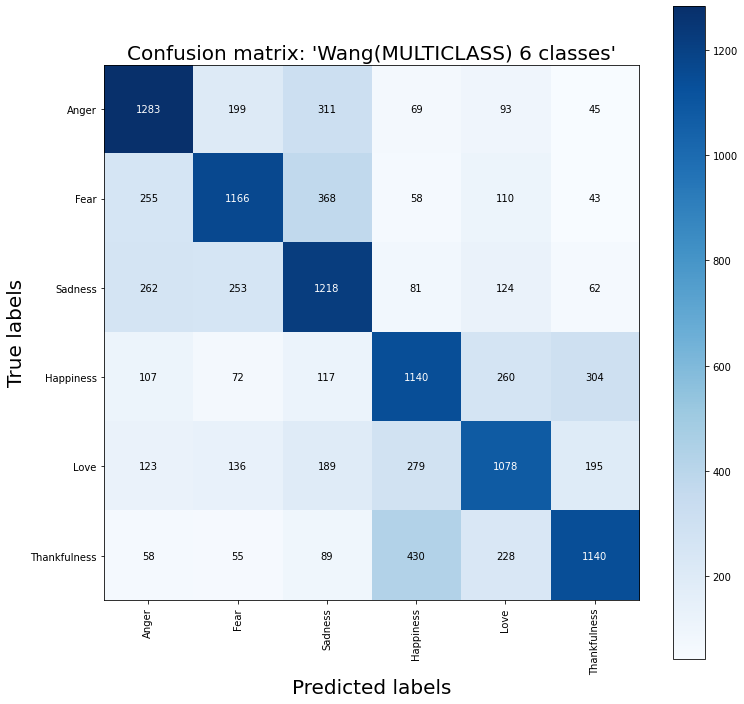

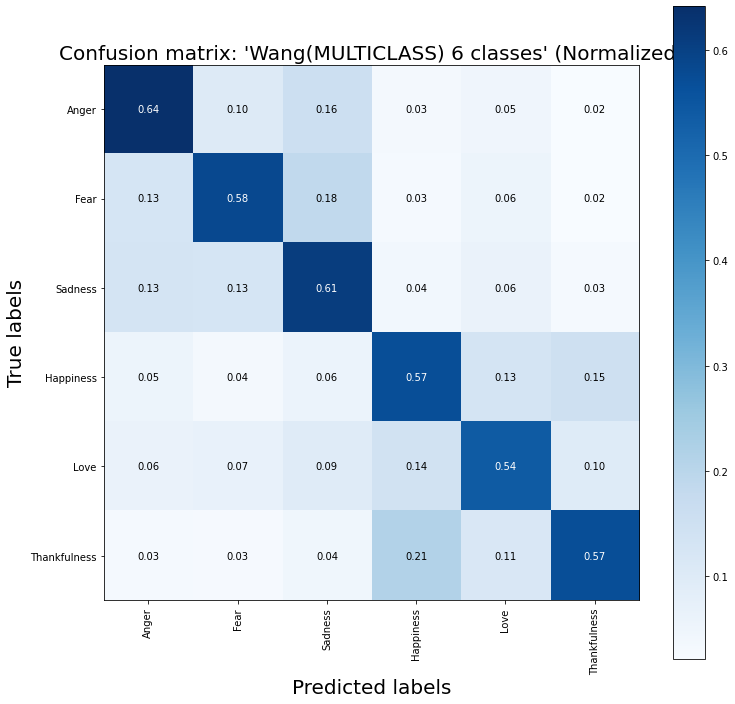

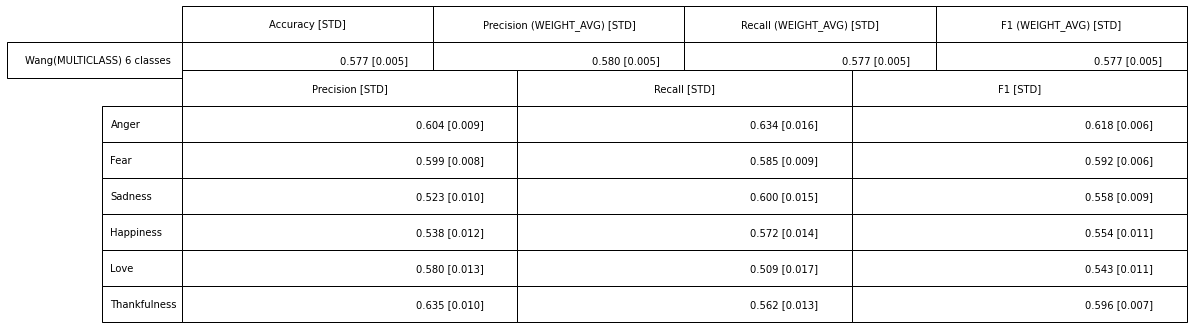

In [ ]:

#Evaluate Vent dataset with 6 emotions using Bert hierarchical classifier model
train_parameters = {
    "num_epochs": 4,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 64,
    "num_timesteps": 35,
    "num_classes_negative": 3,
    "num_classes_positive":3,
    "num_classes":6
}
#The dataset Vent is required to run this cell, which is not provided publicly due to authors restrictions

result = run_multiclass_model("Vent (MULTICLASS) 6 classes", model_parameters, train_parameters, load_vent_hier_6)
parameters = ["Vent (MULTICLASS) 6 classes", model_parameters, train_parameters, load_vent_hier_6]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)